In [55]:
!pip install --upgrade collatex

In [56]:
pip install python-Levenshtein

Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install grapheme

Note: you may need to restart the kernel to use updated packages.


In [438]:
from glob import glob #alle bestandspaden terugvinden die overeenkomen met specifiek patroon
import os #aanmaken van mappen, verwijderen van mappen,...
from itertools import combinations #reeks verzameling cijfers/letters, combinaties in lexicografische volgorde
import grapheme #voor stringmanipulatie & rekenfucties -> stel je hebt x = 'n̄', dan len(x) = 2 (want 2 bytes), grapheme.length(x) is dan wel 1
from collatex import * #alle functies van collatex importeren, * geeft weer dat het om alle functies gaat
from tqdm import tqdm #progress meters toevoegen
import numpy as np #numpy dient om met lijsten/arrays te werken 
import pandas as pd #gebruik maken van de functies van Panda, zoals pd.DataFrame
import seaborn as sb #statistical data visualization
import matplotlib.pyplot as plt #creating static/animated/interactive visualizations

In [439]:
sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob('../data/xml_martijn/*.xml')] #maak een lijst van sigles, doe dat door de basisnaam van een specifiek path te nemen (fn) en daarin .txt te vervangen, for... in ... = loop
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'G',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [440]:
#sigles = 'A', 'B', 'C', 'D'
#sigles = 'A','Ant','B', 'BR', 'C','D', 'D2','E', 'F', 'G', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'

In [572]:
from lxml import etree
from re import sub #re — Regular expression operations #
import xml.etree.ElementTree as ET
import string


NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'} #namespace = collectie van 'symbolic names'
removes = ('teiHeader', 'fw', 'supplied', 'abbr') #fw = forme work = headers, footers,...supplied = tekst toegevoegd door de transcriber 
removes_expan_false = ('teiHeader', 'fw', 'supplied', 'ex', 'expan') 


def extract_lines(xml_file, expan = True, #def = fuctie maken die alleen wordt uitgevoerd als je die oproept, extract_lines = de naam van de functie, xml_file = argument in de functie, na de functienaam in ()
                  punct = True, lower = True,
                  sep_abbr = True): 
    
    lines = {}
    tree = etree.parse(xml_file) #ElementTree represents the whole XML document as a tree, and Element represents a single node
    
    
    if expan:
        #delete all elements with the provided tag names from a tree or subtree
        #will also remove the tail text unless explicitly set the with_tail keyword argument option to False
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False) 
    else: 
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes_expan_false), with_tail=False)
    

    gaps = []   
    
    for text_element in tree.iterfind('.//'+"{"+ NSMAP["MVN"]+ "}" + "text"):
        for line_element in tree.iterfind('.//'+"{"+ NSMAP["MVN"]+ "}"+'l'):
            if(line_element.find('.//'+"{"+ NSMAP["MVN"]+ "}"+'gap')) is not None :
                gaps.append(text_element.attrib)
                gaps.append(line_element.attrib['n'])
    print(gaps) #hier proberen M1, M2... aan gaps toe te voegen
                
    #for line_element in tree.iterfind('.//'+"{"+ NSMAP["MVN"]+ "}"+'l'): #add namespace because otherwise it won't find the element gap/finds all matching subelements
        #if(line_element.find('.//'+"{"+ NSMAP["MVN"]+ "}"+'gap')) is not None : #verwijder alle lijnen met een damage gap
            #gaps.append(line_element.attrib['n'])
    
    #print(gaps) #hier proberen M1, M2... aan gaps toe te voegen
    chars = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'}
            
    context = etree.iterwalk(tree, events=("start", "end")) #a tree walker generates events from an existing tree. 'Start' and 'end' represent opening and closing elements
    #u prefix indicates Unicode
    text = u"" #een lege string die tekst heet, u staat voor Unicode 
    #this will be the key in the dictionary of lines {}
    k = '' 
    
    for action, node in context: #bij elke actie bij een element/knooppunt in het overlopen van het xml bestand
        #remove ns for easier access
        #tag_only bevat de tags op een knooppunt
        #.tag selects all child elements with the given tag. A tag is a string identifying what kind of data this element represents (the element type, in other words).
        #.replace removes ns www.tei...
        
        tag_only = node.tag.replace("{http://www.tei-c.org/ns/1.0}","") 
            
        #node.attrib: XML elements have attributes 
        #attrib is a dictionary containing the element’s attributes. 
        if 'n' in node.attrib and tag_only == 'text': 
            title = node.attrib['n'] #for example Eerste Martijn
    
        if 'n' in node.attrib and tag_only == "l":                
            k = title + '-' + node.attrib['n'] #for example 001, 002, 003...
  
        # if a new pb (standalone element) is processed:
        if action == 'start' and tag_only == 'text': 
            continue
            
        # if new lb (standalone) is processed:
        elif action == 'start' and tag_only == 'lb':
            continue

        # list elements which you want to iterate through. this is not really neccessary.
        elif tag_only in ("group","text","MVN","body","cb","p"):
            continue

        # for all other elements, distinguish between the start-event of the processing and
        # and the end-event. Attach the tail AFTER the child nodes were processed (= end-event) 
         
        elif action == 'start':
            #comment the following two lines out to not get the element markers
            #f.write(f"[{tag_only}]") 
            #text += f"[{tag_only}]"

            ############################################################################
            ########## filter out special characters, bars,                   ##########
            ########## superscript, or specific tags.                         ##########
            ############################################################################
                    
            
            #if a special glyph is present, encode it accordingly
            if tag_only == 'g':
                if sep_abbr: #extra toegevoegd door Mike.  
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u005f' #low line _

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770' 

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += '\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'

                    else:
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left
                    
                else:
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u0304'

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770'

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += u'\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'

                    else:
                        node.attrib['ref']
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left

            # encode superscript letters
            superscript_dict = {'a':'ᵃ', 'b':'ᵇ', 'c':'ᶜ', 'd':'ᵈ', 'e':'ᵉ', 'f':'ᶠ',
                               'g':'ᵍ', 'h':'ʰ', 'i':'ᶦ', 'j':'ʲ', 'k':'ᵏ', 'l':'ˡ', 
                                'm':'ᵐ', 'n':'ⁿ', 'o':'ᵒ', 'p':'ᵖ', 'r':'ʳ', 's':'ˢ', 
                                't':'ᵗ', 'u':'ᵘ', 'v':'ᵛ', 'w':'ʷ', 'x':'ˣ', 'y': 'ʸ', 'z': 'ᶻ'}

            if tag_only == 'hi' and 'rend' in node.attrib and node.attrib['rend'] == 'superscript': #rend(ition) supplies information about the appearance of an element
                if node.text in superscript_dict:
                    text += str(superscript_dict[node.text]).strip()

            # encode punctuation marks
            elif tag_only == 'pc':
                text += str(node.text).strip()

            # encode roman numerals
            elif tag_only == 'num':
                if node.text:
                    text += str('.'+node.text+'.').strip()

            # if there is still a node with text in it
            elif (node.text):
                text += node.text        

        # after the child elements
        elif action == 'end':
            #if there is a tail
            #the tail attribute holds the text between the element’s end tag and the next tag, or None
            if (node.tail and node.tail not in "\t"): #if the tail is not yet in the text 
                #comment the following two lines out to not get the tail marker
                #text += "[tail]"
                #f.write("[tail]")
                #append to text-concatenation
                text += str(node.tail)
                
        if tag_only == 'lb':
            if k:
                text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                if not punct:
                    text = text.translate(str.maketrans('', '', string.punctuation)) #the value of the keys k is the text 
                if lower: 
                    text = text.lower()
                   
                    #text = text[::-1]
                  
                lines[k] = text #the value of the keys k is the text 
                text = ''    
    #print(lines)
    
    
    lines = {k:v for k, v in lines.items() if v.strip()} #if a line with a gap is removed, remove empty key, strip() removes spaces #The items() method returns a key-value pair
#dictionary filteren 
    return lines

d = extract_lines(f'../data/xml_martijn/xml_{sigles[0]}.xml', expan = False, punct = False, lower = True)

#print(d)


[{'{http://www.w3.org/XML/1998/namespace}id': 'Martijn'}, {'{http://www.w3.org/XML/1998/namespace}id': 'Martijn'}, {'{http://www.w3.org/XML/1998/namespace}id': 'Martijn'}, {'{http://www.w3.org/XML/1998/namespace}id': 'Martijn'}, {'{http://www.w3.org/XML/1998/namespace}id': 'Martijn'}, {'n': 'Eerste Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M1'}, {'n': 'Eerste Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M1'}, {'n': 'Eerste Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M1'}, {'n': 'Eerste Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M1'}, {'n': 'Eerste Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M1'}, {'n': 'Tweede Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M2'}, {'n': 'Tweede Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M2'}, {'n': 'Tweede Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M2'}, {'n': 'Tweede Martijn', '{http://www.w3.org/XML/1998/namespace}id': 'M2'}, {'n': 'Tweede Martijn', '{http://www.w3

In [384]:
mss = {} #dictionary maken van manuscripten

for sigle in tqdm(sigles): #for... in = loop, toont progress meter 
    mss[sigle] = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml',
                               expan = True, punct = False, lower = True,
                               sep_abbr = False) #f string waarin 'sigle' wordt ingevuld
    
print(mss['A'])

100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 45.73it/s]

{'Eerste Martijn-001': 'vvaphene martin hoe salt gaen', 'Eerste Martijn-002': 'sal die weerelt hiet langhe staen', 'Eerste Martijn-003': 'in dus crancken loue', 'Eerste Martijn-004': 'so moet vrouwe vereere saen', 'Eerste Martijn-005': 'sonder twifel ende waen', 'Eerste Martijn-006': 'rumen heeren houe', 'Eerste Martijn-007': 'ic zie den valschen wel ontfaen', 'Eerste Martijn-008': 'die de heeren conen dwaen', 'Eerste Martijn-009': 'ende plucken vanden stoue', 'Eerste Martijn-010': 'ende ic zie den rechten slaen', 'Eerste Martijn-011': 'beede bespotten ende beuaen', 'Eerste Martijn-012': 'alse die meese in de cloue', 'Eerste Martijn-013': 'rechts offene god verscroue', 'Eerste Martijn-014': 'hoe langhe sal ghedoghen dit', 'Eerste Martijn-015': 'god die alle dinc besit', 'Eerste Martijn-016': 'in sine heerscapie', 'Eerste Martijn-017': 'dat die goede vleeuwet ende bit', 'Eerste Martijn-018': 'ende hem ne doech no dat no dit', 'Eerste Martijn-019': 'dat hi hiet ghedie', 'Eerste Martijn-0

print(mss.keys()) #print de keys van de dictionary mss 

In [342]:
# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def align_nw(x, y, match = 1, mismatch = 1, gap = 1): #nw needleman-wunsch,  'def' = functie header/functienaam = unieke naam voor functie waarmee deze aangeroepen kan worden.Tussen haakjes zet je parameters.
    x = list(grapheme.graphemes(x)) #body van de functie. functie voert specifieke taak uit en  argumenten die zijn ingegeven w omgezet in een output
    y = list(grapheme.graphemes(y)) #door met .grapheme te werken telt het n̄ als 1 en niet als 2 
    
    nx = len(x) # length of first sequence 
    #print(nx)
    ny = len(y) # length of second sequence
    #print(ny)
    
    # Optimal score at each possible pair of characters.
    # Initialization process - forming the base matrix
    F = np.zeros((nx + 1, ny + 1)) #Return an array/reeks van de lengte van x en y, telkens +1, filled with zeros.
    F[:,0] = np.linspace(0, -nx, nx + 1) #[first_row:last_row , column_0] #de eerste rij en laatste rij van de eerste kolom (van 0 tot -22, met interval van 23)
    F[0,:] = np.linspace(0, -ny, ny + 1) #de eerste kolom, eerste en laatste getal van de rij, np.linspace = Return evenly spaced numbers over a specified interval.
    #print (F)
    
    # Pointers to trace through an optimal aligment. Aanknopingspunten om een optimale alignering te traceren. Initialize a pointer matrix P
    P = np.zeros((nx + 1, ny + 1)) #weer een reeks van de lengte van x en y, telkens +1, gevuld met nullen
    P[:,0] = 3 #eerste kolom = 3
    P[0,:] = 4 #eerste rij = 4
    #print(P)
    
    
    # Temporary scores.
    t = np.zeros(3) #[0.0.0.] t is a three-element matrix that stores three values: Match or mutation between the first and second sequence (what would be the score representation → trying to find the least); Inserting a gap inside of the first sequence (addition); Inserting a gap inside of the second sequence (deletion)
    for i in range(nx): #loop over de range die gaat van 0 tot 21
        for j in range(ny): #loop over de range die gaat van 0 tot 22 
            if x[i] == y[j]: # Iteration step: take the max (inserting gap in first sequence, inserting gap in second sequence, match or mutation)       
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t) #neemt het maximum van de rijen
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = rx[::-1]
    ry = ry[::-1]
    return rx, ry #Met een return statement geeft je een output waarde uit een functie.

a, b = align_nw('en̄ niet sceldē dē heʼe', 'en̄ niet scelden dē here')
print(a)
print(b)

['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', '-', 'ē', ' ', 'd', 'ē', ' ', 'h', 'e', 'ʼ', 'e']
['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', 'e', 'n', ' ', 'd', 'ē', ' ', 'h', 'e', 'r', 'e']


In [343]:
def align_collatex(l1, l2):
    A = [{'t': c, 'n': c} for c in grapheme.graphemes(l1)] #t staat voor diplomatisch (text), n staat voor normalized, loop over al de characters 
    
    B = [{'t': c, 'n': c} for c in grapheme.graphemes(l2)]
    json_form = {'witnesses': [{'id': 'A', 'tokens': A}, #witnesses is het root element, hierin zitten de te vergelijken versies, elke versie heeft een unieke id
                               {'id': 'B', 'tokens': B}]
                } #de inhoud zijn de tokens, hierboven gedefinieerd 

    A, B = str(collate(json_form, output='table')).split('\n')[1:3] #split() splits a string into a list

    A = A.replace('| A | ', '').replace(' | ', '').replace(' |', '') #haal de | en sigles weg
    B = B.replace('| B | ', '').replace(' | ', '').replace(' |', '')
    
   
    A = list(grapheme.graphemes(A))
    B = list(grapheme.graphemes(B))
    
    return A, B

a, b = align_collatex('en̄ niet sceldē dē heʼe', 'en̄ niet scelden dē here')
print(a)
print(b)

['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', 'ē', ' ', ' ', 'd', 'ē', ' ', 'h', 'e', 'ʼ', 'e']
['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', 'e', 'n', ' ', 'd', 'ē', ' ', 'h', 'e', 'r', 'e']


In [344]:
def get_distances(mss, method='NW'): #needleman-wunsch
    distances = [] #een lijst maken 
    for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))): # combinations('ABCD', 2) --> AB AC AD BC BD CD #eerste element van combinatie w opgeslagen in ms1 en tweede waarmee je vergelijkt in ms2, 
        common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys())) #een set maken, items in a set are unordered #The intersection() method returns a set that contains the similarity between two or more sets, 
    #for loop doet eerst AB BA..., dan zorgt intersection er voor dat AB gebeurt maar niet BA ook nog eens 
        for idx in common_idxs: #A, Ant,... 
            line1, line2 = mss[ms1][idx], mss[ms2][idx] #zoekt binnen dictionary naar de sigle (value 1), en geeft dan de eerste regel tekst (value 2) 
            if method == 'NW': #compare two methods: nw and collatex 
                rx, ry = align_nw(line1, line2) #verwijs naar bovenstaande functies 
            elif method == 'CollateX':
                rx, ry = align_collatex(line1, line2)
            if len(rx) != len(ry): #is niet gelijk aan, dan wordt line 1 en line 2 geprint
                print(line1, line2)
            length = len(rx)
            for idx, (a, b) in enumerate(zip(rx, ry)): #You get the index with enumerate(), and get the elements of multiple iterables with zip().
                if a != b:
                    distances.append((ms1, ms2, idx/length, 1, a, b))
                else:
                    distances.append((ms1, ms2, idx/length, 0, a, b))
    return pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch', 'char1', 'char2'))

In [345]:
nw_mismatches = get_distances(mss, method='NW') 
cx_mismatches = get_distances(mss, method='CollateX')
nw_mismatches.sample(5) #.sample returns a list with a randomly selection of a specified number of items from a sequence
cx_mismatches.sample(5)

100%|█████████████████████████████████████████| 136/136 [05:43<00:00,  2.53s/it]


,ms1,ms2,position,mismatch,char1,char2
1682604,O,Z,0.600000,0,i,i
1255441,D,Y,0.766667,0,e,e
1068532,D,F,0.733333,0,n,n
946027,C,G,0.000000,0,d,d
844771,C,D,0.333333,0,l,l


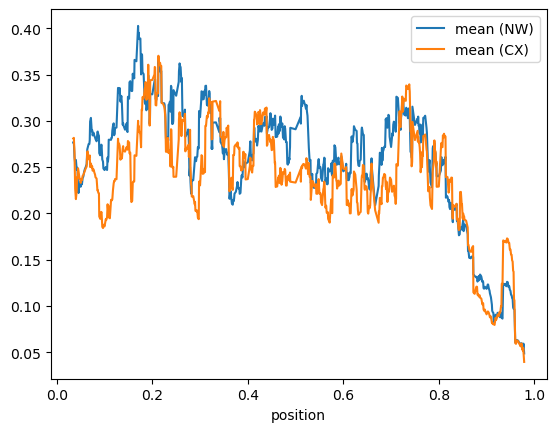

In [360]:
nw_rolling_window = nw_mismatches.groupby('position')['mismatch'].mean().rolling(window=20).mean() # groupby() function is used to split the data into groups based on some criteria. 
cx_rolling_window = cx_mismatches.groupby('position')['mismatch'].mean().rolling(window=20).mean() #gemiddelde nemen

ax = nw_rolling_window.plot(label="mean (NW)")
cx_rolling_window.plot(label="mean (CX)", ax=ax)

plt.legend() #met afkortingen gaat het op het einde omhoog, zonder daalt het 
plt

In [361]:
#checken of de resultaten statistisch significant zijn en dat is zo!
#mismatches_end = mismatches[mismatches['position'] > .75]
#mismatches_beginning = mismatches[mismatches['position'] <= .75]
#from scipy.stats import mannwhitneyu
#mannwhitneyu(mismatches_end['mismatch'], mismatches_beginning['mismatch'], alternative='less')

## Clustermap

In [362]:
for ms in mss:
    print(ms, len(mss[ms]))

A 1762
Ant 0
B 1820
BR 568
C 1469
D 1821
D2 136
E 275
F 1821
G 1766
Ge 70
K 66
L 507
O 1823
W 506
Y 272
Z 528


In [363]:
sigles = sorted(mss.keys())
print(sigles)
sigles = [s for s in sigles if len(mss[s]) >= 506]
print(sigles)

['A', 'Ant', 'B', 'BR', 'C', 'D', 'D2', 'E', 'F', 'G', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z']
['A', 'B', 'BR', 'C', 'D', 'F', 'G', 'L', 'O', 'W', 'Z']


In [364]:
df_clust = np.zeros((len(sigles), len(sigles)))  #Return an array/reeks van de lengte van x en y, gevuld met nullen.
print(df_clust.shape) #The shape property is usually used to get the current shape of an array

(11, 11)


In [365]:
for s1, s2 in combinations(sigles, 2):
    print(s1, s2)
    d = nw_mismatches[(nw_mismatches['ms1'] == s1) & (nw_mismatches['ms2'] == s2)]['mismatch'].mean()
    df_clust[sigles.index(s1), sigles.index(s2)] = d #Python index() = function which searches for a given element from the start of the list and returns the index of the first occurrence. 
    df_clust[sigles.index(s2), sigles.index(s1)] = d

A B
A BR
A C
A D
A F
A G
A L
A O
A W
A Z
B BR
B C
B D
B F
B G
B L
B O
B W
B Z
BR C
BR D
BR F
BR G
BR L
BR O
BR W
BR Z
C D
C F
C G
C L
C O
C W
C Z
D F
D G
D L
D O
D W
D Z
F G
F L
F O
F W
F Z
G L
G O
G W
G Z
L O
L W
L Z
O W
O Z
W Z


In [236]:
df_clust = pd.DataFrame(df_clust, columns=sigles, index=sigles)
df_clust

,A,B,BR,C,D,F,G,O,W,Z
A,0.000000,0.142704,0.157438,0.151761,0.177940,0.156250,0.161539,0.166604,0.156493,0.186198
B,0.142704,0.000000,0.179111,0.158403,0.174391,0.167856,0.176156,0.172038,0.167019,0.199320
BR,0.157438,0.179111,0.000000,0.168051,0.150128,0.100642,0.141712,0.179249,0.142545,0.131975
C,0.151761,0.158403,0.168051,0.000000,0.177587,0.166602,0.173596,0.174522,0.182013,0.197660
D,0.177940,0.174391,0.150128,0.177587,0.000000,0.147622,0.181414,0.181076,0.199593,0.186113
F,0.156250,0.167856,0.100642,0.166602,0.147622,0.000000,0.153942,0.163700,0.160730,0.145971
G,0.161539,0.176156,0.141712,0.173596,0.181414,0.153942,0.000000,0.181983,0.033210,0.165271
O,0.166604,0.172038,0.179249,0.174522,0.181076,0.163700,0.181983,0.000000,0.182666,0.207999
W,0.156493,0.167019,0.142545,0.182013,0.199593,0.160730,0.033210,0.182666,0.000000,0.181552
Z,0.186198,0.199320,0.131975,0.197660,0.186113,0.145971,0.165271,0.207999,0.181552,0.000000


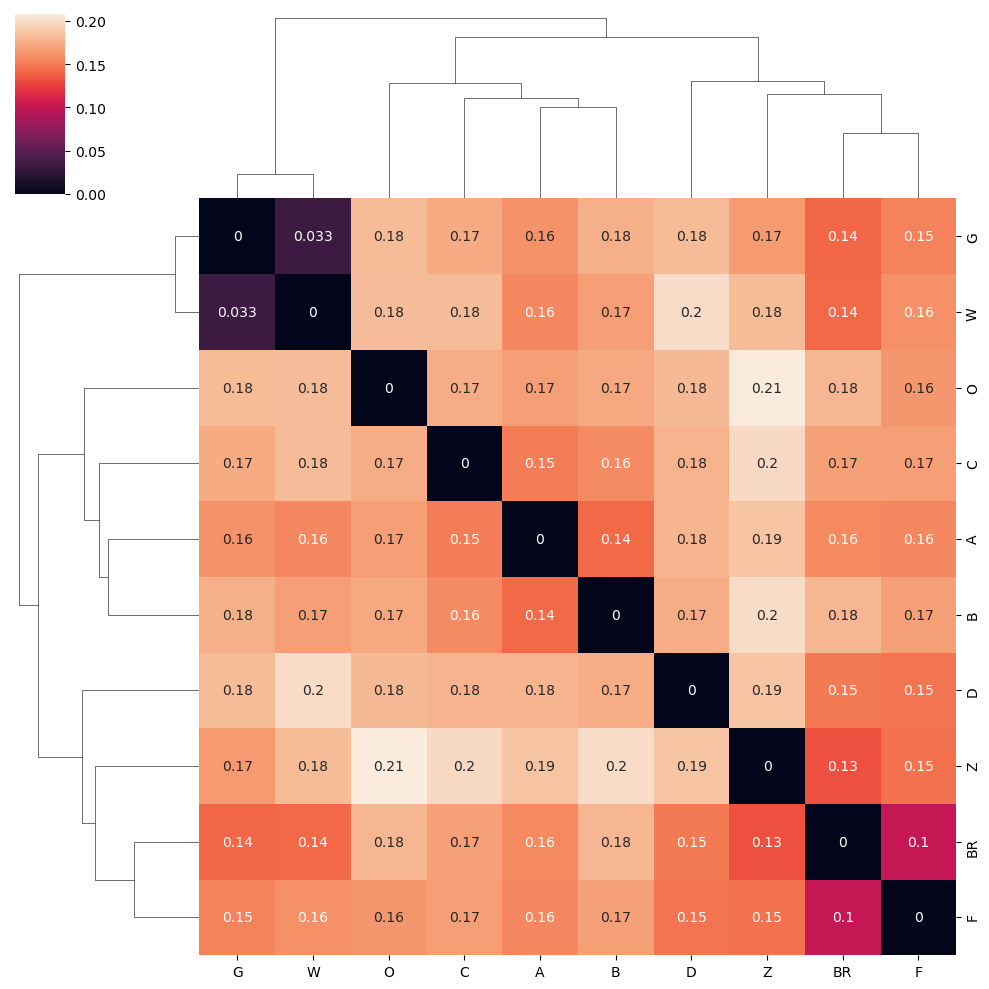

In [238]:
import seaborn as sb
sb.clustermap(df_clust, method='ward', annot=True);

## Abbreviation density

In [20]:
abbr_density = []

for sigle in sigles: #loop
    abbr = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml', expan = False, punct = False, lower = True)
    expan = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml', expan = True, punct = False, lower = True)
    
    line_idxs = sorted(abbr.keys())
    abbr_lens = np.array([len(abbr[line]) for line in line_idxs])
    expan_lens = np.array([len(expan[line]) for line in line_idxs])
    
    diffs = pd.Series(expan_lens - abbr_lens)
    ratios = pd.Series(abbr_lens / expan_lens)
    abbr_density.append((sigle, diffs.mean(), diffs.std(), ratios.mean(), ratios.std()))

dens = pd.DataFrame(abbr_density, columns=['sigle', 'diff-mean', 'diff-std', 'ratio-mean', 'ratio-std'])
dens.dropna(inplace=True)
dens.set_index('sigle', inplace=True)

In [21]:
dens

,diff-mean,diff-std,ratio-mean,ratio-std
sigle,,,,
A,1.281658,1.267670,0.954306,0.043616
B,1.113187,1.178113,0.959807,0.041200
BR,1.207746,1.148180,0.955133,0.040983
C,0.402314,0.824205,0.985216,0.030835
D,0.138386,0.516288,0.995722,0.015790
F,0.600769,0.958123,0.979705,0.031948
G,3.004515,1.701291,0.892987,0.057011
O,0.558420,0.905989,0.981547,0.029366
W,1.944664,1.754457,0.931749,0.060387


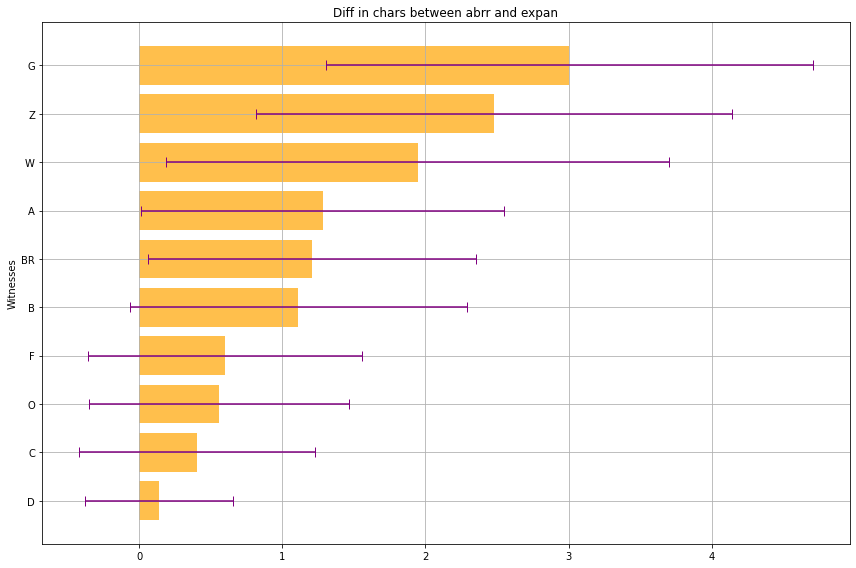

In [22]:
dens.sort_values(by='diff-mean', inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(dens.index)), dens['diff-mean'],
       xerr=dens['diff-std'],
       color='orange',
       align='center',
       alpha=0.7,
       ecolor='purple',
       capsize=5)
ax.set_ylabel('Witnesses')
ax.set_yticks(range(len(dens.index)))
ax.set_yticklabels(dens.index)
ax.set_title('Diff in chars between abrr and expan')
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.tight_layout()

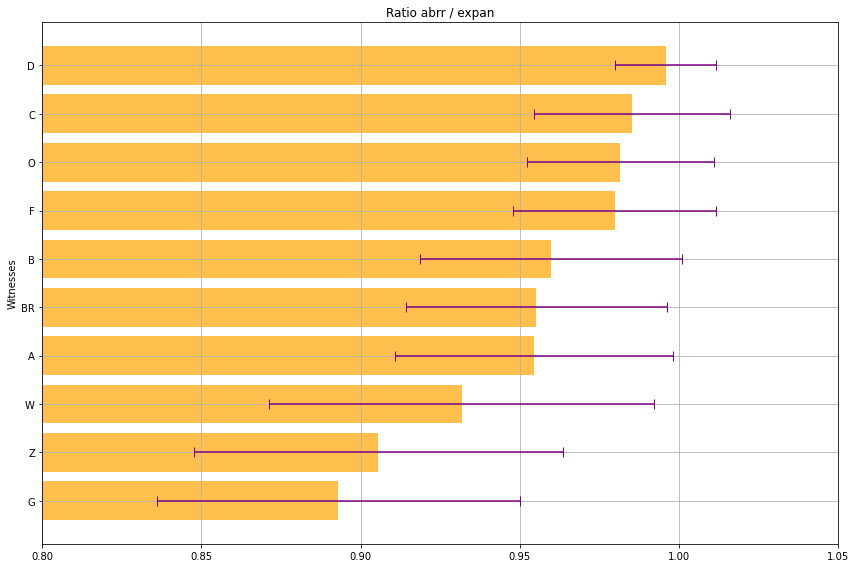

In [23]:
dens.sort_values(by='ratio-mean', inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(dens.index)), dens['ratio-mean'],
       xerr=dens['ratio-std'],
       color='orange',
       align='center',
       alpha=0.7,
       ecolor='purple',
       capsize=5)
ax.set_ylabel('Witnesses')
ax.set_yticks(range(len(dens.index)))
ax.set_yticklabels(dens.index)
ax.set_title('Ratio abrr / expan')
plt.xlim(0.8, 1.05)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.tight_layout()

## Pixelplot

In [573]:
all_lines = set()
for ms in mss:
    all_lines.update(mss[ms].keys())

def repl(n):
    n = n.replace('Eerste Martijn', '1')
    n = n.replace('Tweede Martijn', '2')
    n = n.replace('Derde Martijn', '3')
    n = n.replace('Vierde Martijn', '4')
    return n

all_lines = [repl(l) for l in all_lines]
all_lines = sorted(all_lines)
ms_names = sorted(mss.keys())
grid = np.ones((len(all_lines), len(mss.keys())))
grid.shape

for ms in mss:
    for line in mss[ms]:
        grid[all_lines.index(repl(line)), ms_names.index(ms)] = 0

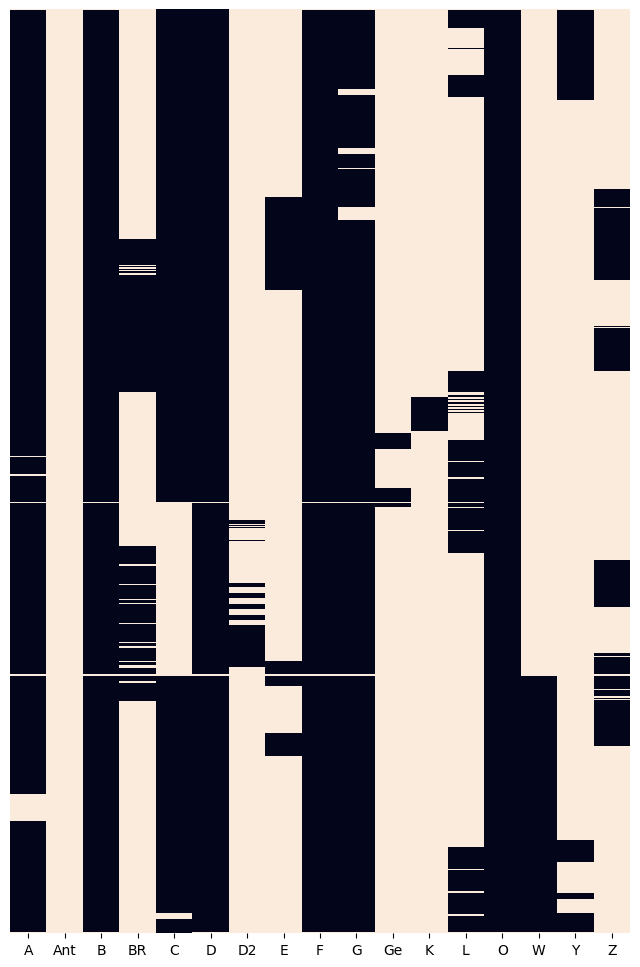

In [574]:
fig, ax = plt.subplots(figsize=(8, 12))
sb.heatmap(grid, xticklabels=ms_names, yticklabels=False, ax=ax, cbar=False);